# Prototyping pointilism project
Notebook to prototype turning images in points

In [53]:
import numpy as np
from PIL import Image, ImageDraw
import imageio
from matplotlib import pyplot as plt
from IPython.display import display

from random import random
from math import sqrt
from math import floor,ceil
import os

## Bring in an image

In [2]:
image_orig = Image.open('IMG_0290.jpg')

In [61]:
def cropY(image,aspect,resize):
    """Crops image in the height dimension to 
    match aspect ratio of width by height"""
    w = image.size[0]
    h = image.size[1]
    h_new = w*aspect[1]/aspect[0]
    image = image.crop((0,h/2 - h_new/2,
                        w,h/2 + h_new/2))
    if resize: image = image.resize([aspect[0],aspect[1]])
    return image

((3968, 2976), (3968, 1984))


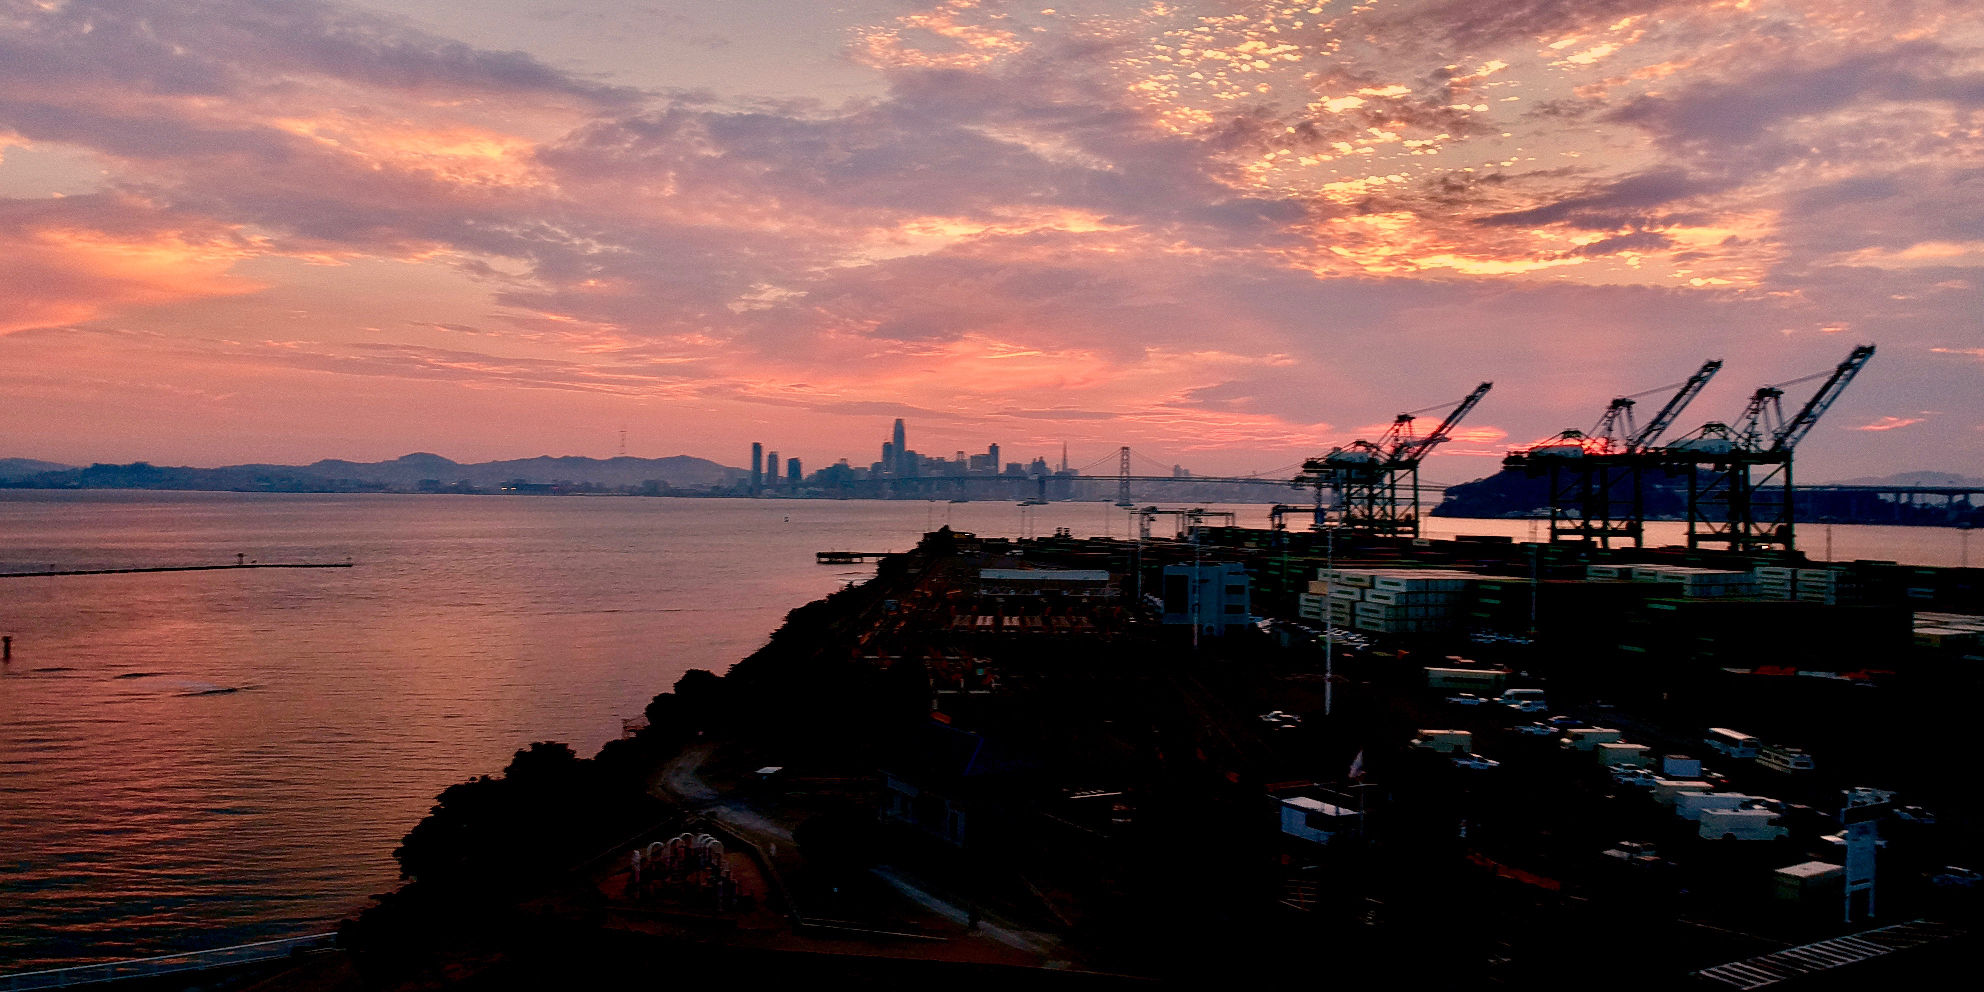

In [25]:
# Crop
image_crop = cropY(image_orig,[2,1], False)
print(image_orig.size, image_crop.size)
display(image_crop.resize([image_crop.size[0]/2,image_crop.size[1]/2]))

In [5]:
# Get np array of image
np_image = np.array(image_crop).astype('float')

## Define functions for simple rectangular plotting

In [6]:
def getColorOfPixel(array, loc, r):
    """Returns RGB tuple [0,255] of average color of the np array
    of an image within a square of width 2r at location loc=[x,y]"""
    left = max(loc[0]-r,0)
    right = min(loc[0]+r,array.shape[1])
    bottom = max(loc[1]-r,0)
    top = min(loc[1]+r,array.shape[0])
    x = range(left,right)
    y = range(bottom,top)
    if len(x) == 0 | len(y) == 0: return (255,255,255)
    R = int(array[np.ix_(y, x, [0])].mean())
    G = int(array[np.ix_(y, x, [1])].mean())
    B = int(array[np.ix_(y, x, [2])].mean())
    #if (np.isnan(R) | np.isnan(G) | np.isnan(B)): R,G,B = 255,255,255
    return (R,G,B)
    

In [7]:
def plotColorPoint(image, array, border,loc, r):
    """Plots point at loc with size r with average color from 
    same in array"""
    color = getColorOfPixel(array,loc,r)
    draw = ImageDraw.Draw(image)
    w = image.size[0]
    h = image.size[1]
    # Correct for PIL using TL indexing instead of BL
    #draw.ellipse((loc[0]-r, h-(loc[1]+r),loc[0]+r,h-(loc[1]-r)),color + (255,))
    draw.ellipse((border+loc[0]-r, (border+loc[1]-r),
                  border+loc[0]+r,(border+loc[1]+r)),
                  color + (255,))
   

In [8]:
def plotRecPoints(image, array,border,r,step, fill):
    """Plots rectangular array of points over an image array,
    if fill is True, fills frame, otherwise leaves border"""
    h = array.shape[0]
    w = array.shape[1]
    if fill:
        for x in [int(x) for x in np.linspace(0, w, w/step)]:
            for y in [int(y) for y in np.linspace(0, h, h/step)]:
                plotColorPoint(image, array, border, [x,y], r)
    else:
        
        for x in [int(x) for x in np.linspace(r, w-r, w/step)]:
            for y in [int(y) for y in np.linspace(r, h-r, h/step)]:
                plotColorPoint(image, array, border, [x,y], r)

In [9]:
def newImageWithBorder(image,border):
    h = image.size[1]
    w = image.size[0]
    image_out = Image.new('RGBA',[w+border*2, h+border*2],(255,255,255,0))
    #note must make base RBG for this
    #image_out.paste(image,[border,border,w+border,h+border]) 
    return image_out

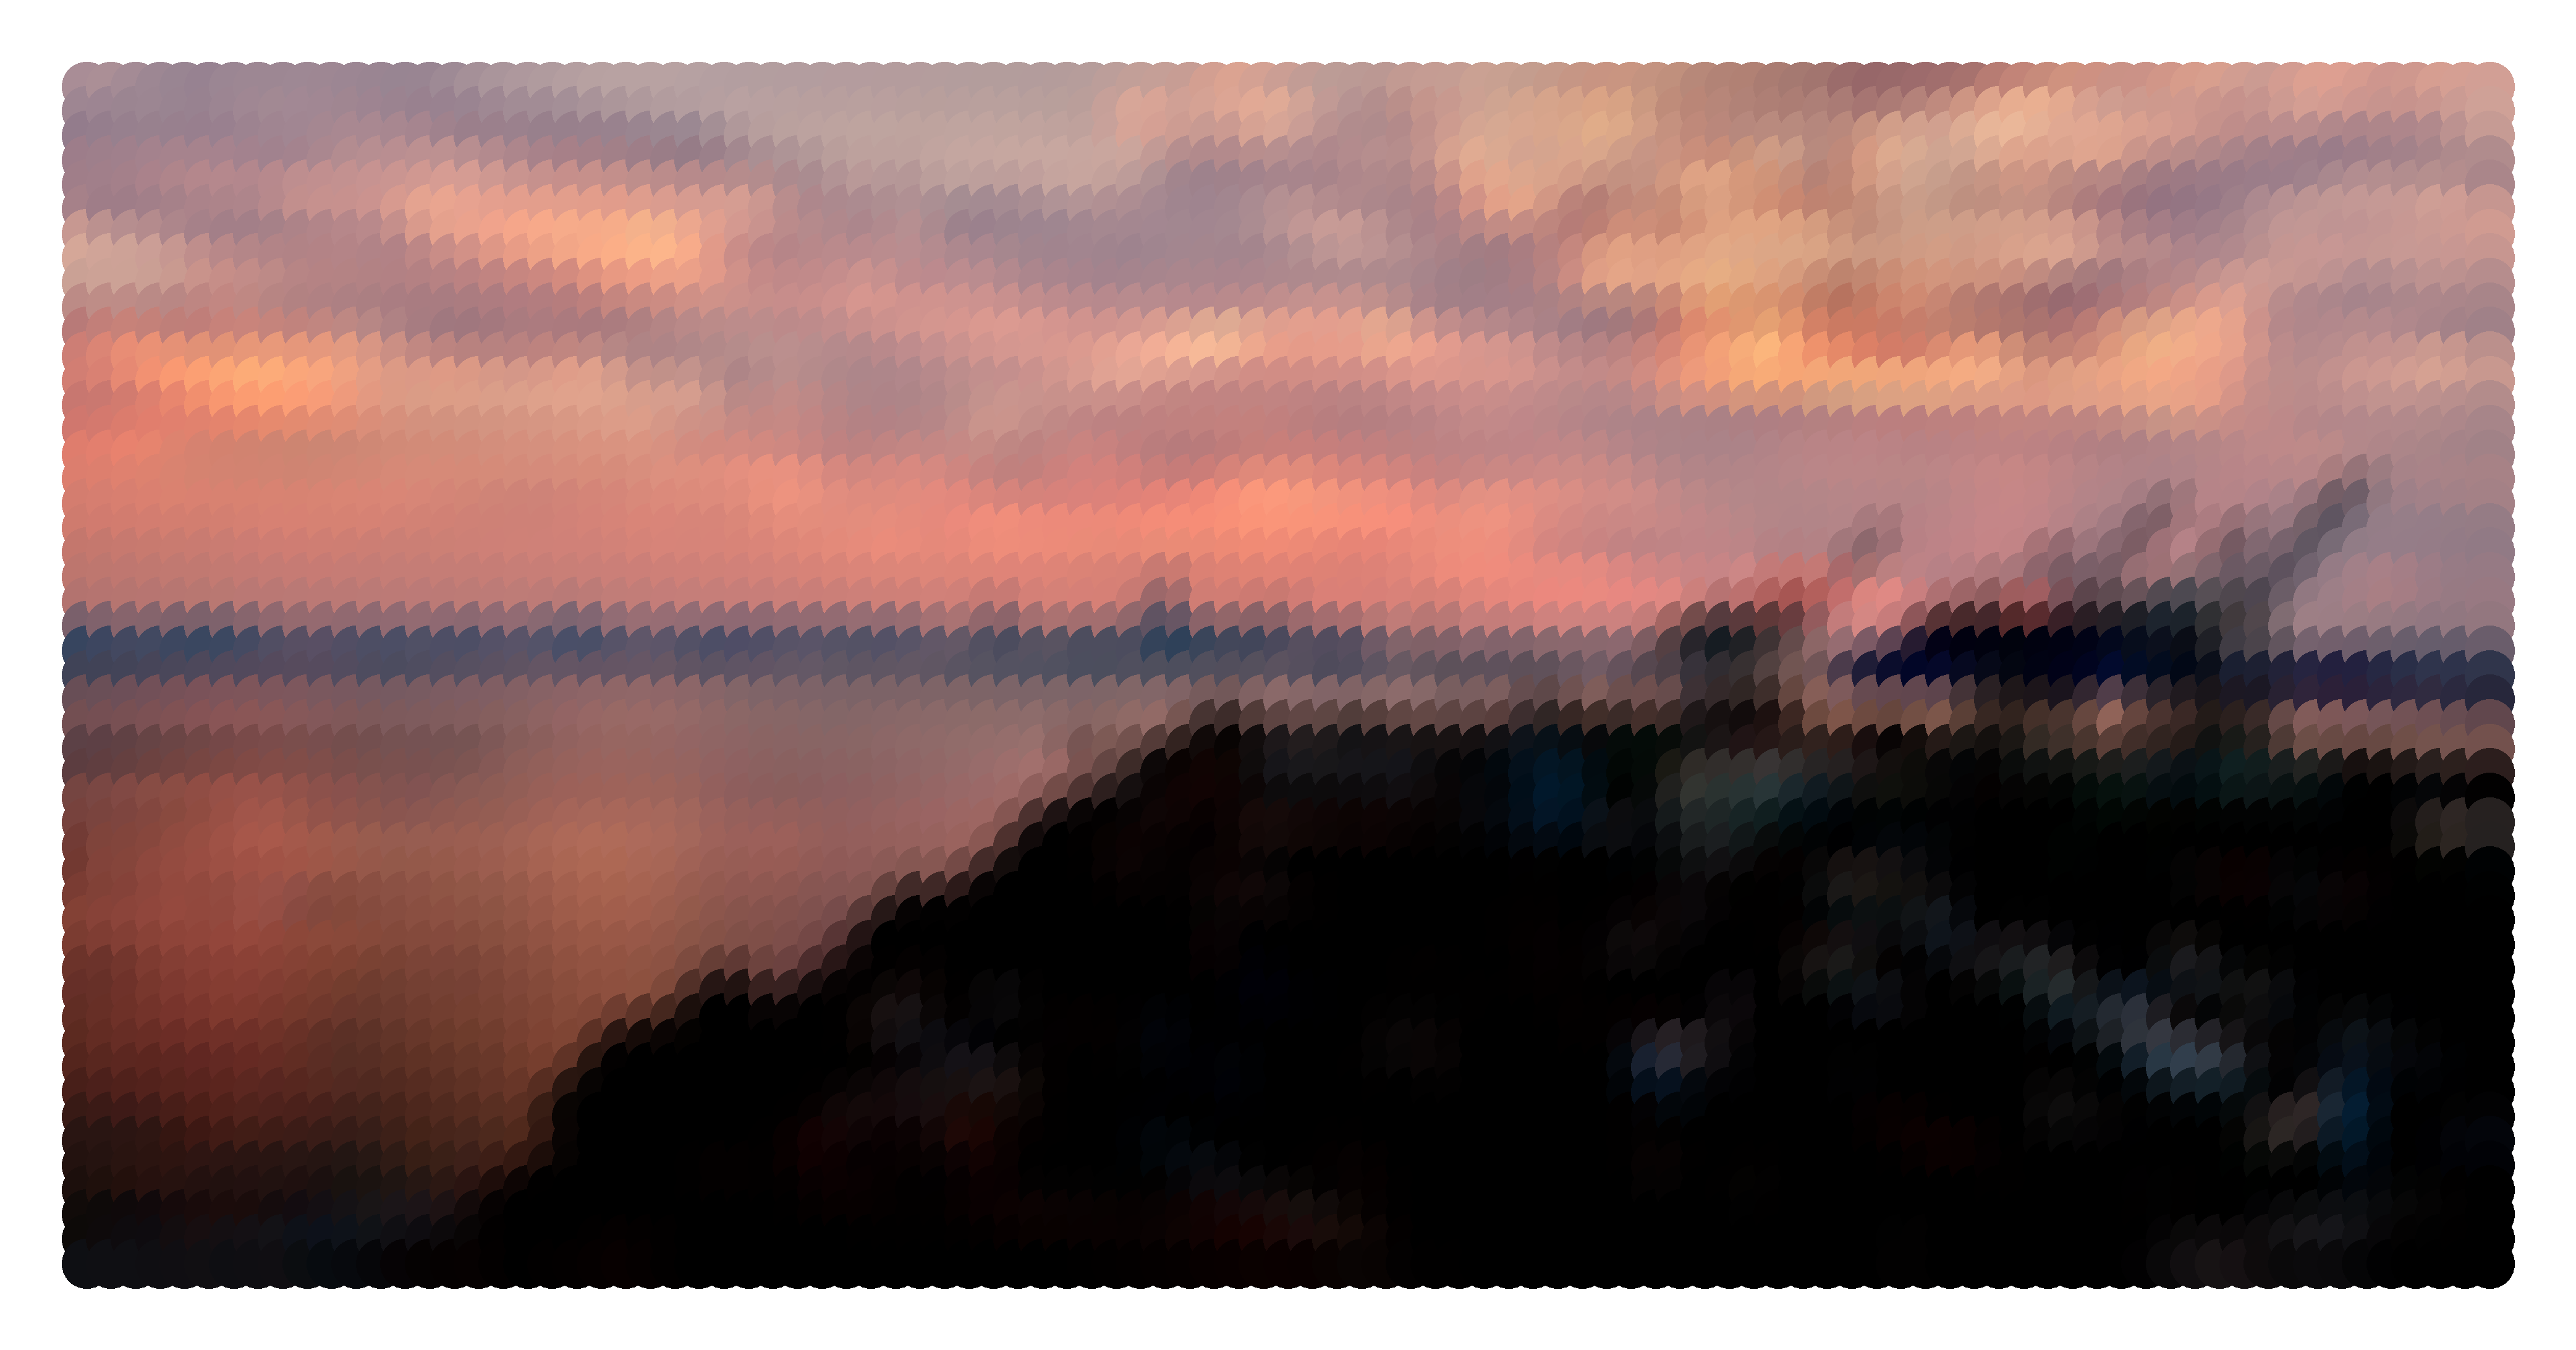

In [10]:
border = 100
image_out = newImageWithBorder(image_crop,border)
plotRecPoints(image_out,np_image,border,40,40,False)
#draw = ImageDraw.Draw(image_out,'RGBA')
#draw.rectangle([border,border,w+border,h+border],(255,0,0,100))
image_out

## Now random plotting

In [11]:
def plotRandomPoints(image, array,border, n, constant, power):
    """plots random points over image, where constant is
    the portion of the width for the max size of the bubble, 
    and power pushes the distribution towards smaller bubbles"""
    h = array.shape[0]
    w = array.shape[1]
    for i in range(0,int(n)):
        loc = [int(random()*w), int(random()*h)]
        r = int((random()/2)**(power)*w*constant)*2**power+1
        plotColorPoint(image,array,border,loc,r)

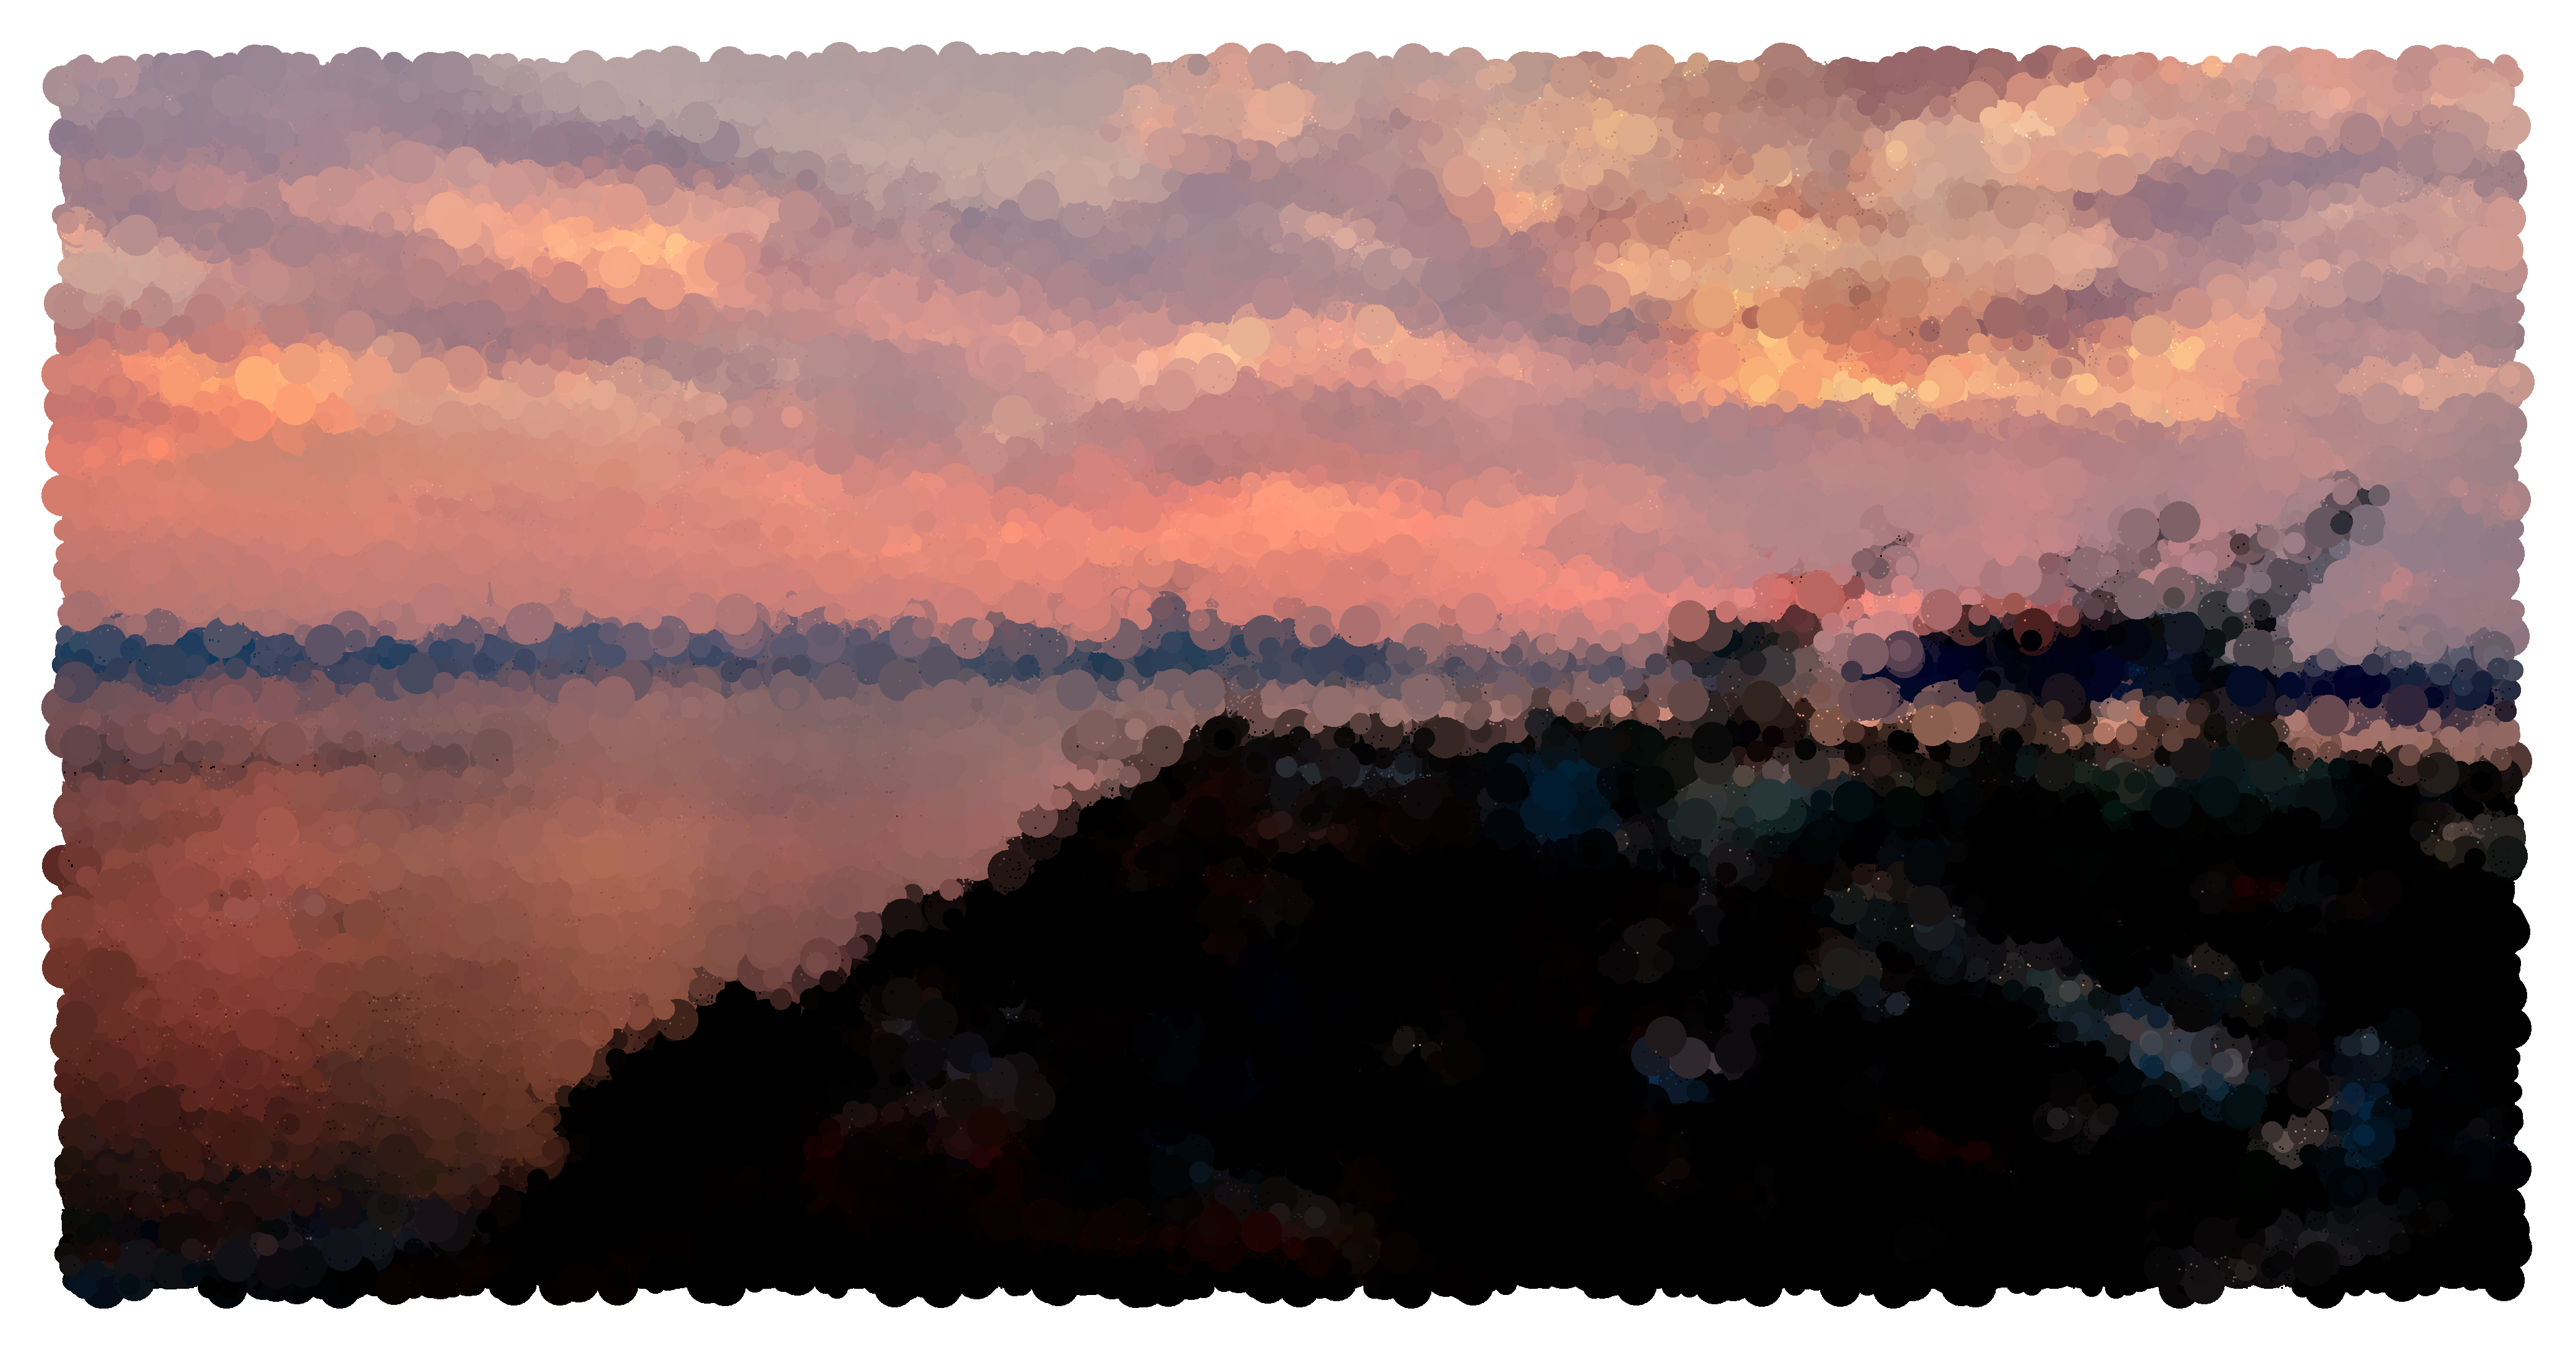

In [12]:
image_out = newImageWithBorder(image_crop,border)
plotRecPoints(image_out,np_image,border,50,50,False)
plotRandomPoints(image_out,np_image,border,1e5,0.01,4)
image_out

In [13]:
image_out.save('out - 01-4-1e5 - power, bordered, normed.png')

## Now make complexity function

In [14]:
def getComplexityOfPixel(array, loc, r):
    """Returns value [0,1] of average color of the np array
    of an image within a square of width 2r at location loc=[x,y]"""
    left = max(loc[0]-r,0)
    right = min(loc[0]+r,array.shape[1])
    bottom = max(loc[1]-r,0)
    top = min(loc[1]+r,array.shape[0])
    x = range(left,right)
    y = range(bottom,top)
    if len(x) == 0 | len(y) == 0: return 0
    R = array[np.ix_(y, x, [0])].max() - array[np.ix_(y, x, [0])].min()
    G = array[np.ix_(y, x, [1])].max() - array[np.ix_(y, x, [1])].min()
    B = array[np.ix_(y, x, [2])].max() - array[np.ix_(y, x, [2])].min()
    if (np.isnan(R) | np.isnan(G) | np.isnan(B)): R,G,B = 0,0,0
    return 1-(R+G+B)/(255*3.0)

In [15]:
def plotRandomPointsComplexity(image, array,border, n, constant, power):
    """plots random points over image, where constant is
    the portion of the width for the max size of the bubble, 
    and power pushes the distribution towards smaller bubbles"""
    h = array.shape[0]
    w = array.shape[1]
    for i in range(0,int(n)):
        loc = [int(random()*w), int(random()*h)]
        r = int((getComplexityOfPixel(array,loc,10)/2)**(power)*w*constant*2**power+1)
        plotColorPoint(image,array,border,loc,r)

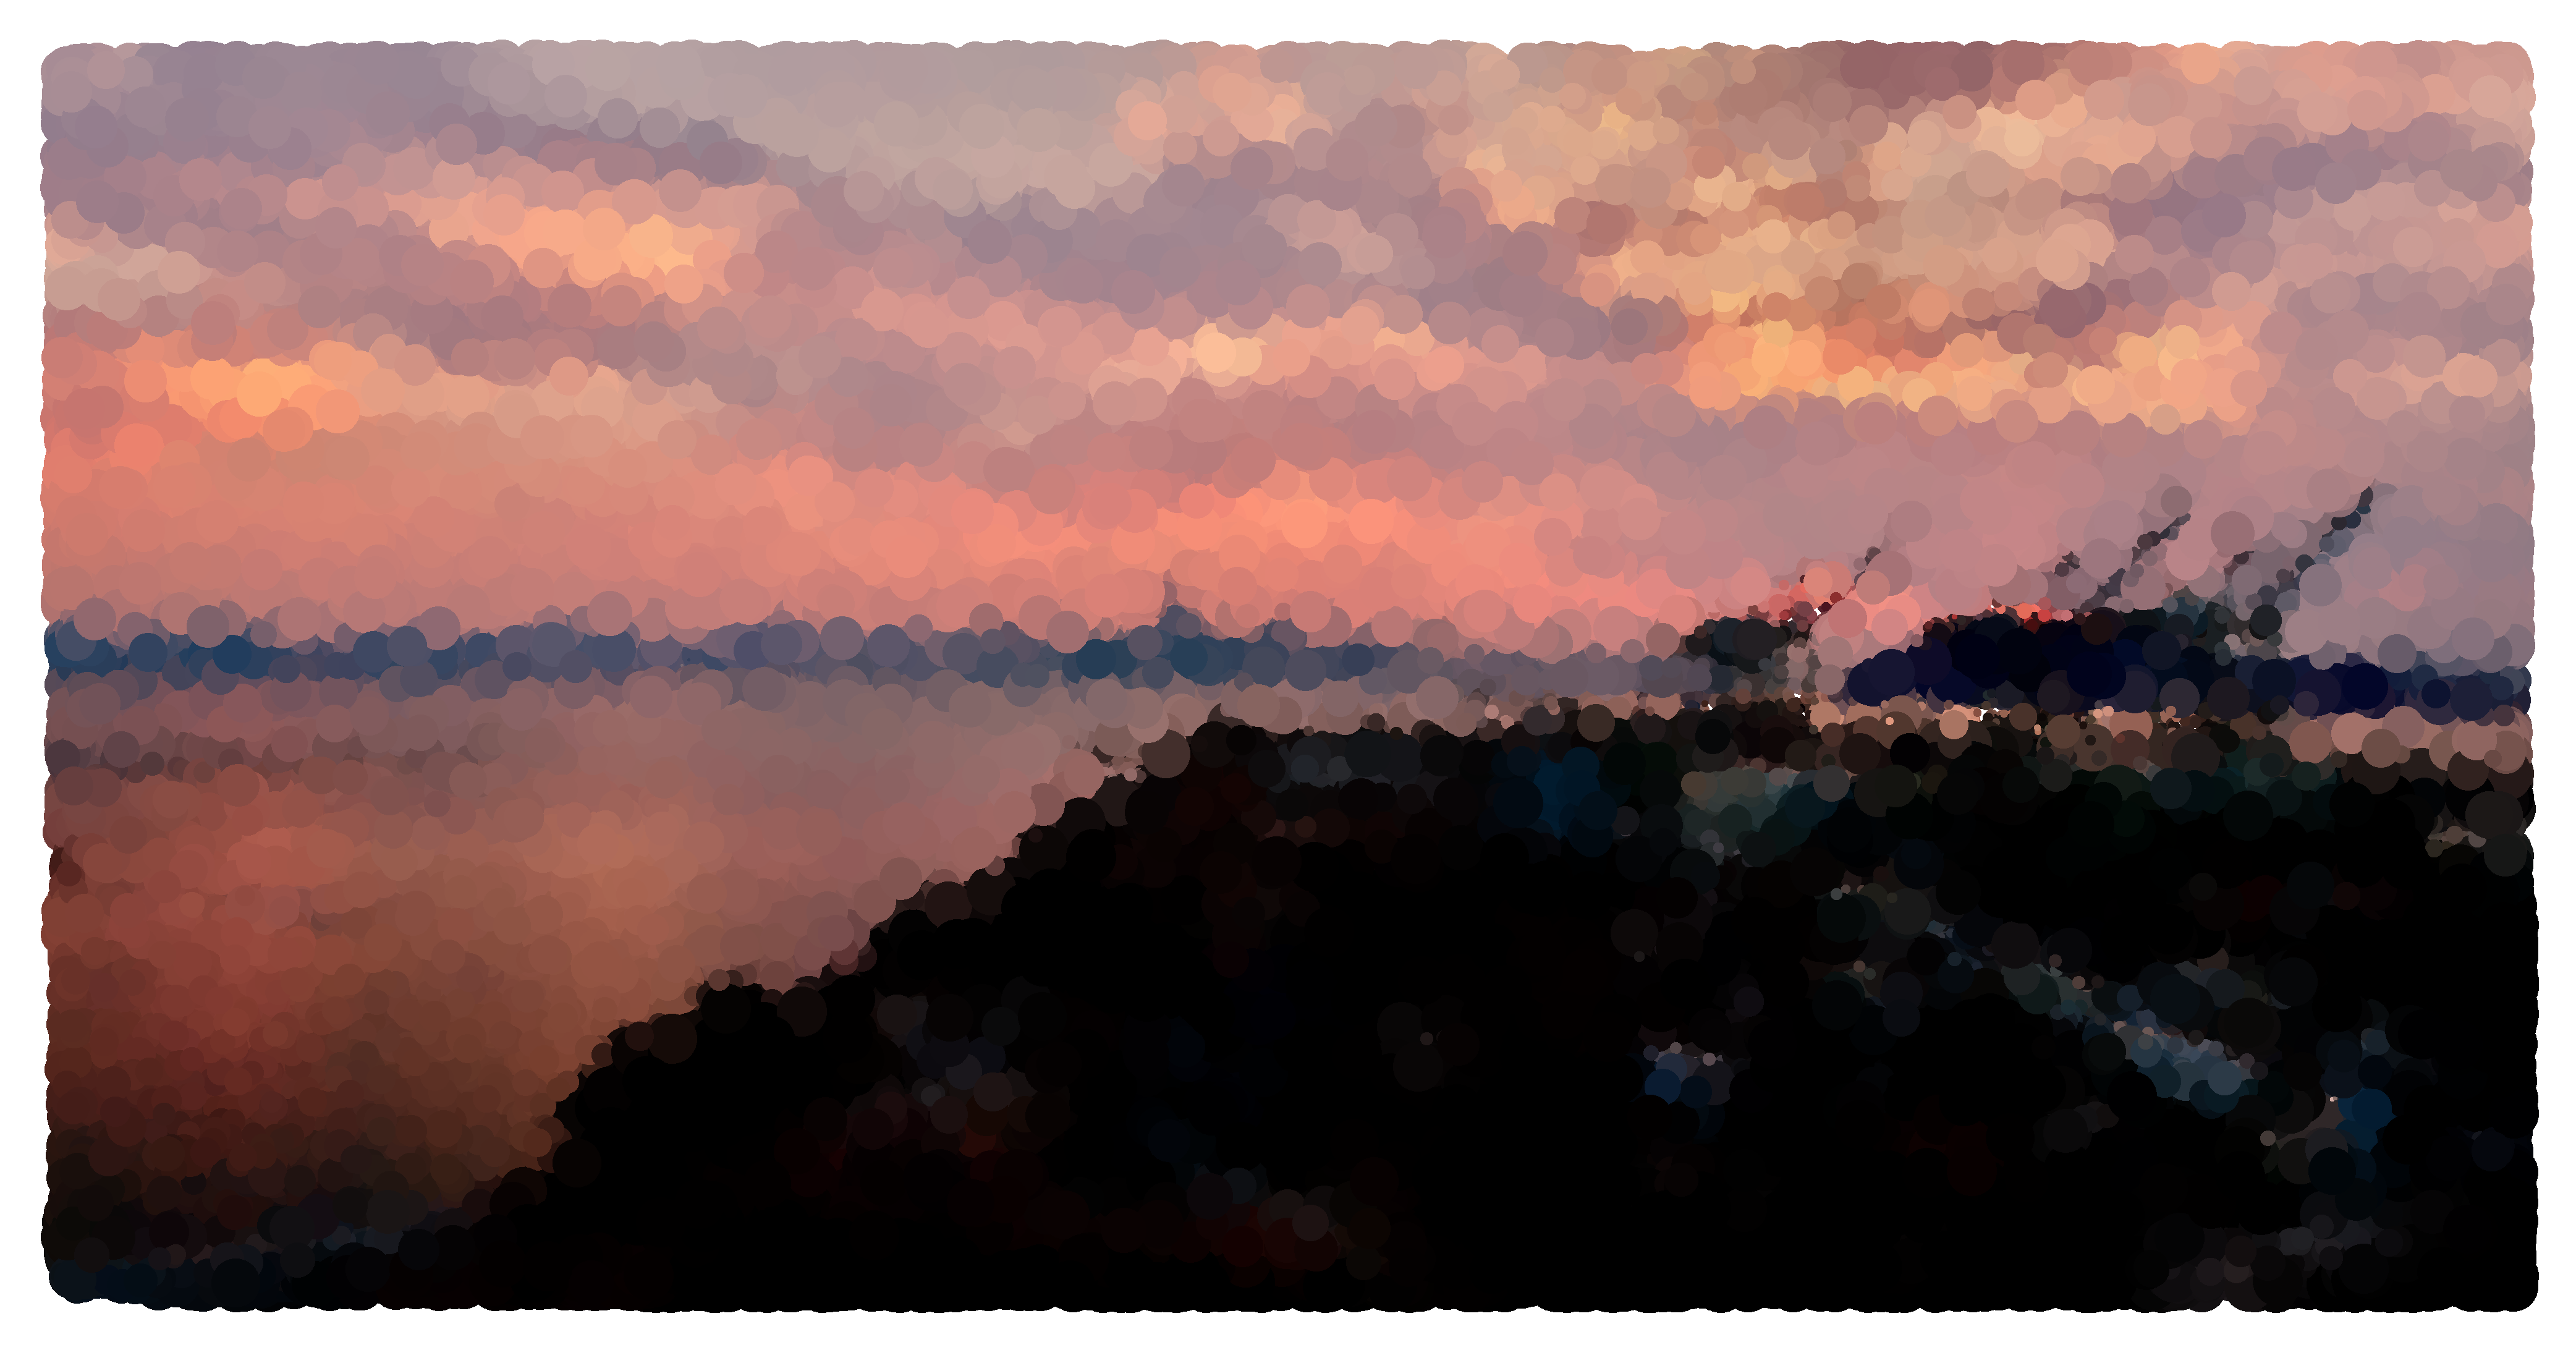

In [16]:
border = 100
image_out = newImageWithBorder(image_crop,border)
plotRandomPointsComplexity(image_out, np_image, border,1e5,0.01,1.3)
image_out

## Wrap it up quickly for executing

In [17]:
def pointillismWrapper(location,save):
    """Takes either directory or file and passes to pipeline""" 
    if os.path.isdir(location):
        for file in os.listdir(location):
            if file.endswith(".jpg"): 
                print(file)
                pointillismPipeline(location+'/'+file,save)
    else:
        print(location)
        pointillismPipeline(location,save)

In [33]:
def pointillismPipeline(filename,save):
    """Example pipeline for creating image"""
    
    border = 100
    image = Image.open(filename)
    image = cropY(image,[2,1], False)
    
    np_image = np.array(image).astype('float')
    image_out = newImageWithBorder(image,border)
    
    plotRecPoints(image_out, np_image, border,40,40, fill=False)
    plotRandomPointsComplexity(image_out, np_image, border,1e4,0.01,1.2)
    #plotRandomPoints(image_out, np_image, border,1e2,0.01,4)
        
    if save: image_out.save(filename +' 1e1-01-4' + '.png')
    display(image_out.resize([image_out.size[0]/2,image_out.size[1]/2]))

IMG_0290.jpg


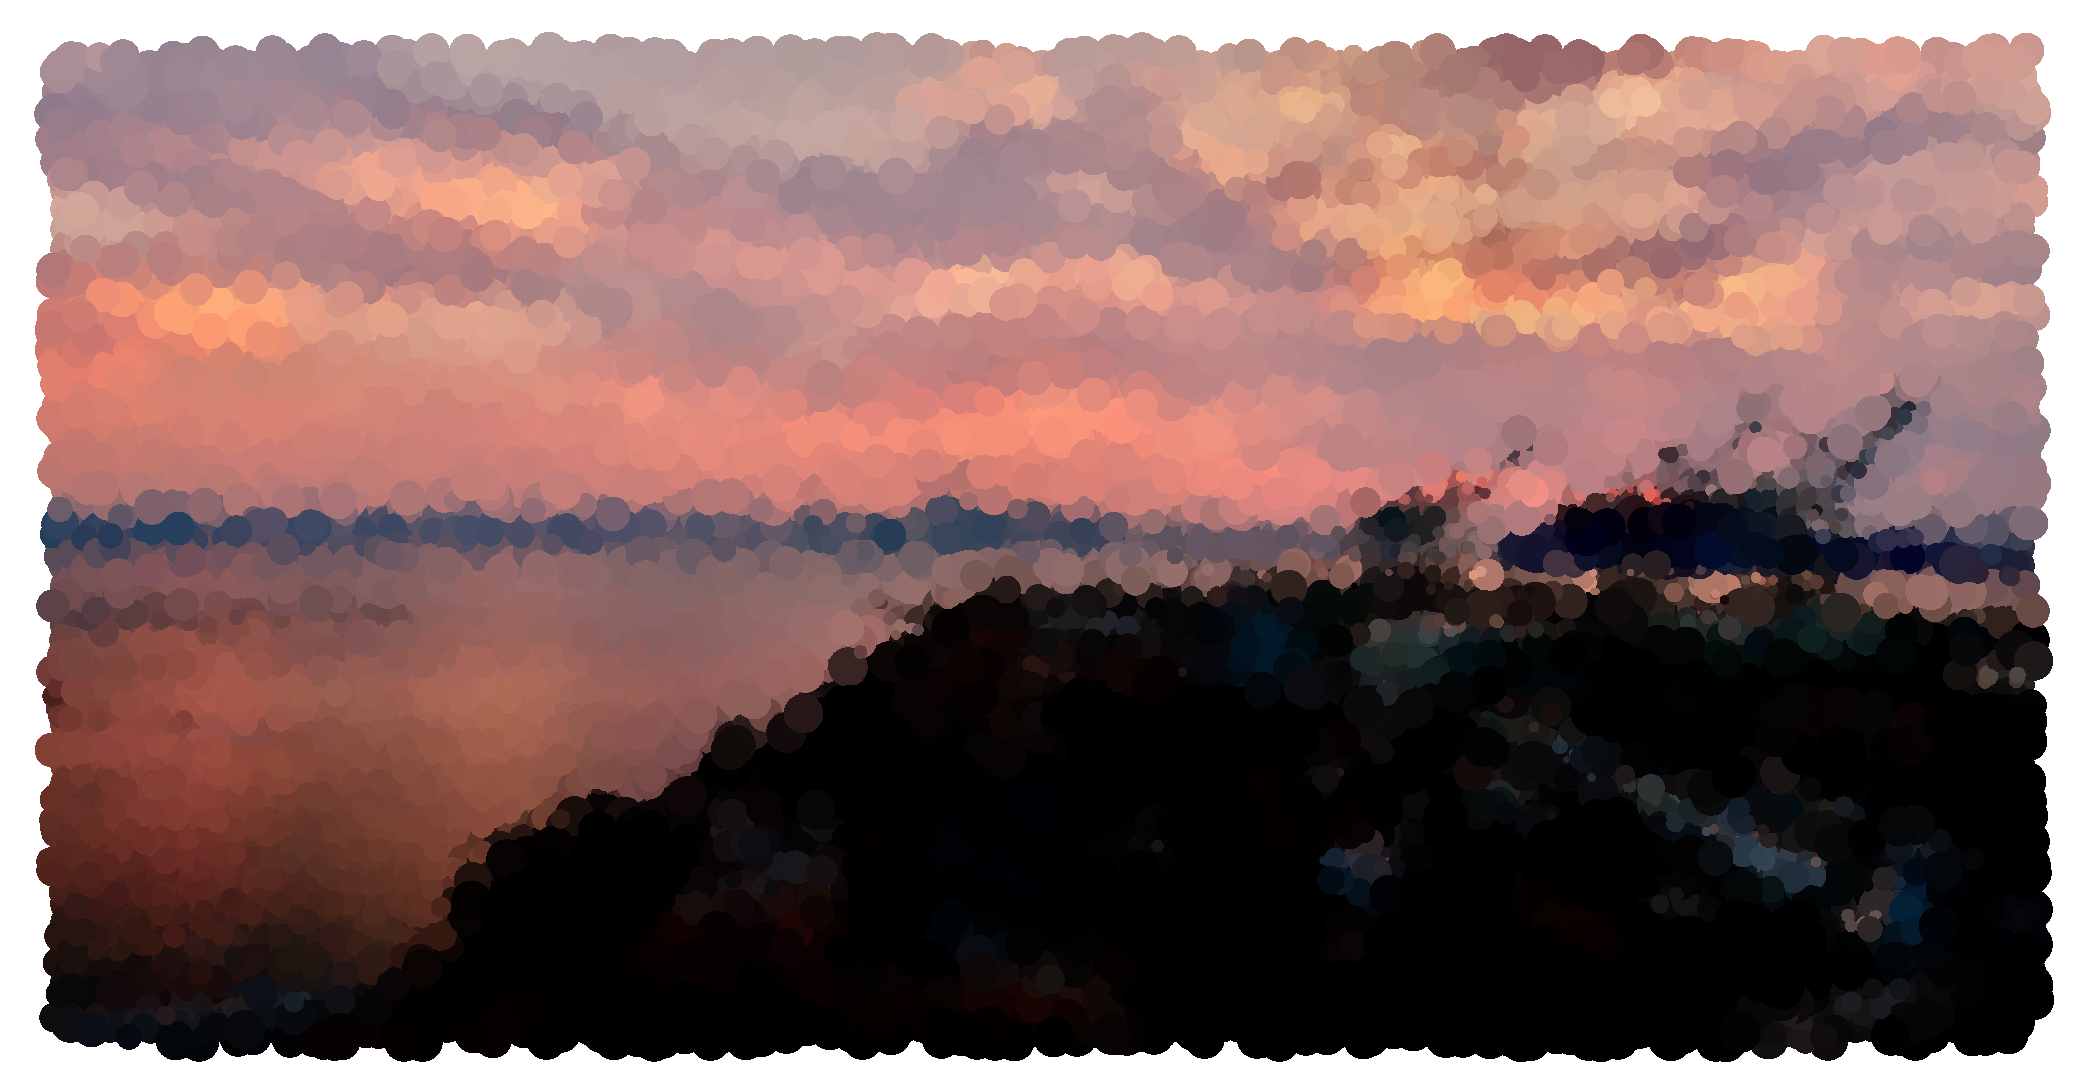

In [34]:
pointillismWrapper('IMG_0290.jpg',save=False)
#pointillismWrapper('images_all/',save=False)

## Save out sequence as GIF

In [78]:
def pointillismPipelineGIF(filename,n):
    """Example of GIF pipeline. Returns sequence of images and np.arrays"""
    
    images = []
    arrays = []
    
    for i in range(0,n):
        border = 0
        image = Image.open(filename)
        image = cropY(image,[2000,1000], True)
        np_image = np.array(image).astype('float')
        image_out = newImageWithBorder(image,border)

        plotRecPoints(image_out, np_image, border,40,40, fill=False)
        #plotRandomPoints(image_out, np_image, border,1e4,0.01,2)
        plotRandomPointsComplexity(image_out, np_image, border,1e5,0.01,1.2)
        
        images.append(image_out)
        arrays.append(np.array(image_out))
        
    return images,arrays 

In [79]:
images, arrays = pointillismPipelineGIF('IMG_0290.jpg',10)

In [80]:
imageio.mimsave('example_animated.gif', arrays, duration = .1)

In [85]:
from IPython.display import HTML
HTML('<img src="example_animated.gif">')

# Working section and notes:

## Ideas
* Gif of construction, easy
* Gif (looped) of various iterations, kind of like rain
* Make manual composites of coarse and fine bubble images to capture detail
